# Analysis of Real Estate Prices and Features in King County, Seattle 

![img](./images/kc_header.png)

(image courtesy of [beautifulwashington.com](https://beautifulwashington.com/king-county.html))

**Authors / Contributors:**

- Luke Dowker
- Jawwad Siddiqui
- Xiaohua Su

# Overview

**Recommendations:**

1. `sqft_living` correlates with price - but there's no need to go **huge**!
2. Build homes that feature a scenic `view`
3. Ensure the material `grade` of the home is high-quality

# Business Problem

UNIQUE  that specializes in **new builds** wants to know what **attributes** of a home will produce positive effects on the property's **sale price** - they are looking to minimize risk and maximize ROI. What aspects of the property should they **focus on** when constructing new homes?

# Data Investigation and Cleaning

We kick things off by importing all necessary libraries and packages.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
from scipy import stats

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
import sklearn.metrics as metrics
from sklearn.metrics import r2_score
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error

# from random import gauss
# from mpl_toolkits.mplot3d import Axes3D

from statsmodels.formula.api import ols
import statsmodels.api as sm

from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
# Shows *all* columns in dataframe, i.e. does not truncate horizontally
pd.set_option('display.max_columns', None)

# Converts from scientific notation to standard form (applied to every df in
# this notebook) and rounds to two decimal places
pd.set_option('display.float_format', lambda x: '%.2f' % x)

Below, we read in the data and check out some of its basic features: column names, null values, data types, etc.

In [3]:
# Reading in .csv file, creating initial pandas dataframe
df = pd.read_csv('data/kc_house_data.csv')

In [4]:
# Listing out column names
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [5]:
# Checking datatypes and null value counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

**Two components** of this `info` printout that we can immediately identify as problems we may need to address:

1. Columns currently coded as datatype `object`...

    - `date`
    - `waterfront`
    - `view`
    - `condition`
    - `grade`
    - `sqft_basement`


2. Columns currently containing null values...

    - `waterfront`
    - `view`
    - `yr_renovated`

## Initial analysis of descriptive statistics

In [6]:
# Descriptive statistics for numerical columns
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,17755.00,21597.00,21597.00,21597.00,21597.00,21597.00
mean,4580474287.77,540296.57,3.37,2.12,2080.32,15099.41,1.49,1788.60,1971.00,83.64,98077.95,47.56,-122.21,1986.62,12758.28
std,2876735715.75,367368.14,0.93,0.77,918.11,41412.64,0.54,827.76,29.38,399.95,53.51,0.14,0.14,685.23,27274.44
min,1000102.00,78000.00,1.00,0.50,370.00,520.00,1.00,370.00,1900.00,0.00,98001.00,47.16,-122.52,399.00,651.00
25%,2123049175.00,322000.00,3.00,1.75,1430.00,5040.00,1.00,1190.00,1951.00,0.00,98033.00,47.47,-122.33,1490.00,5100.00
50%,3904930410.00,450000.00,3.00,2.25,1910.00,7618.00,1.50,1560.00,1975.00,0.00,98065.00,47.57,-122.23,1840.00,7620.00
75%,7308900490.00,645000.00,4.00,2.50,2550.00,10685.00,2.00,2210.00,1997.00,0.00,98118.00,47.68,-122.12,2360.00,10083.00
max,9900000190.00,7700000.00,33.00,8.00,13540.00,1651359.00,3.50,9410.00,2015.00,2015.00,98199.00,47.78,-121.31,6210.00,871200.00


Looking at the row of `max` values, we can see right away that we have some outliers, values that look as if they depart substantially from the `75%` row; to be more specific, there are some **large, expensive** properties in this dataset.

There's also one property listed with **33 bedrooms** - what's up with that?

In [7]:
df.loc[(df['bedrooms']) == 33]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
15856,2402100895,6/25/2014,640000.00,33,1.75,1620,6000,1.00,NO,NONE,Very Good,7 Average,1040,580.0,1947,0.00,98103,47.69,-122.33,1330,4700


## Basic data cleaning

First, we convert the column `date` to a more usable format; the code below transforms the column to type `datetime64[ns]`.

In [8]:
# Converting column `date` to datetime64[ns] from type string/object
df['date'] = df['date'].astype('datetime64[ns]')

Likewise, the column `grade` is in object format; it provides both a number and a corresponding descriptor, e.g. `5 Fair`. The following code transforms it to a more usable format, one with no whitespace.

In [9]:
# Clean up the values in column `grade` so they are not
# separated by whitespace
df['grade'] = [x.replace(" ", "_").strip() for x in df['grade']]

In [10]:
# Validating that above code worked as intended
df['grade'].value_counts()

7_Average        8974
8_Good           6065
9_Better         2615
6_Low_Average    2038
10_Very_Good     1134
11_Excellent      399
5_Fair            242
12_Luxury          89
4_Low              27
13_Mansion         13
3_Poor              1
Name: grade, dtype: int64

Every house has a unique `id` value, but does every row in the dataset represent a **unique house?**

In [11]:
# Check for multiples in column `id`
df['id'].value_counts()

795000620     3
1825069031    2
2019200220    2
7129304540    2
1781500435    2
             ..
7812801125    1
4364700875    1
3021059276    1
880000205     1
1777500160    1
Name: id, Length: 21420, dtype: int64

Looks like we have a few houses with more than one sale on record! Let's examine a few of the `id` values.

In [12]:
df.loc[(df['id'] == 795000620) |
       (df['id'] == 1825069031) |
       (df['id'] == 2019200220)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
3946,1825069031,2014-08-14,550000.00,4,1.75,2410,8447,2.00,NO,GOOD,Good,8_Good,2060,350.0,1936,1980.00,98074,47.65,-122.09,2520,14789
3947,1825069031,2014-10-16,550000.00,4,1.75,2410,8447,2.00,NaN,GOOD,Good,8_Good,2060,350.0,1936,1980.00,98074,47.65,-122.09,2520,14789
12942,2019200220,2014-09-23,160000.00,3,2.25,1470,8682,1.00,NO,NONE,Average,7_Average,1160,310.0,1985,0.00,98003,47.27,-122.30,1670,8359
12943,2019200220,2015-02-26,269000.00,3,2.25,1470,8682,1.00,NO,NONE,Average,7_Average,1160,310.0,1985,nan,98003,47.27,-122.30,1670,8359
17588,795000620,2014-09-24,115000.00,3,1.00,1080,6250,1.00,NO,NONE,Fair,5_Fair,1080,0.0,1950,0.00,98168,47.50,-122.33,1070,6250
17589,795000620,2014-12-15,124000.00,3,1.00,1080,6250,1.00,NO,NONE,Fair,5_Fair,1080,0.0,1950,0.00,98168,47.50,-122.33,1070,6250
17590,795000620,2015-03-11,157000.00,3,1.00,1080,6250,1.00,NaN,NONE,Fair,5_Fair,1080,0.0,1950,nan,98168,47.50,-122.33,1070,6250


The house with the `id` value `1825069031` saw no change in its sale price between its first sale (in August 2014) and second sale (in October 2014). However, the *other* two houses we're looking at here - `	2019200220` and `795000620` - saw their sale prices **increase** over time, and with no changes in any other column!

It might be best to keep the **most recent** sale on record to avoid adding any additional 'noise' to our model.

In [13]:
# Dropping rows with duplicate values in `id` column,
# sans the most recent sale
df.drop_duplicates(subset=['id'], keep='last', inplace=True)

Let's make sure that worked...

In [14]:
# Ensuring that number of unique `id` values matches
# number of rows in dataframe, i.e. no repeated values
len(df['id'].unique()) == len(df)

True

In [15]:
# Ensuring that only one sale remains for a house
# we know initially had multiple sales on record
df.loc[ df['id'] == 795000620 ]['date']

17590   2015-03-11
Name: date, dtype: datetime64[ns]

We only got one result when indexing into the `date` column for the property `795000620`, and it's the date of the most recent sale on record for `795000620`! We've eliminated *all but the most recent sale* for any property with more than one sale on record.

We no longer have any use for the `id` column, so we can drop it from our dataframe entirely.

In [16]:
print(df['date'].min())
print(df['date'].max())

2014-05-02 00:00:00
2015-05-27 00:00:00


In [17]:
# Dropping `id` column, now that we know we
# have exclusively unique values for `id`

df.drop(labels='id',
        axis=1,
        inplace=True)

**Something else that might be of note:** in some of these rows where the same `id` appears twice, a value that *was* recorded in the first sale appears as a *null value* in a later sale, e.g. the `waterfront` column on the house whose `id` is `1825069031`.

In [18]:
# Creating copy of original dataframe before dropping columns
df_copy = df.copy()

In [20]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21420 entries, 0 to 21596
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           21420 non-null  datetime64[ns]
 1   price          21420 non-null  float64       
 2   bedrooms       21420 non-null  int64         
 3   bathrooms      21420 non-null  float64       
 4   sqft_living    21420 non-null  int64         
 5   sqft_lot       21420 non-null  int64         
 6   floors         21420 non-null  float64       
 7   waterfront     19067 non-null  object        
 8   view           21357 non-null  object        
 9   condition      21420 non-null  object        
 10  grade          21420 non-null  object        
 11  sqft_above     21420 non-null  int64         
 12  sqft_basement  21420 non-null  object        
 13  yr_built       21420 non-null  int64         
 14  yr_renovated   17607 non-null  float64       
 15  zipcode        2142

We've got some nulls in the `view` column, but the number of null values *vis-à-vis*  the number of total rows in the dataframe is such that we can safely drop those nulls without worrying about our conclusions being affected.

In [21]:
# Dropping nulls from column `view`
df_copy = df_copy.dropna(subset = ['view'])

In [22]:
# Validating that...
df_copy['view'].isna().sum() == 0

True

`view` and `grade` might seem similar on first glance - both columns use descriptors like `AVERAGE` and `GOOD` to assess the attributes of a house - but we determined that `grade` is a much more mutable category; it refers to the "types of materials used (in building the house) and the quality of workmanship" on display in the house's "construction and design."

Let's get a breakdown of the distribution of `grade` values in King County.

In [23]:
# Checking out the frequency of each possible value
# for column `grade`
df_copy['grade'].value_counts()

7_Average        8863
8_Good           6029
9_Better         2595
6_Low_Average    1988
10_Very_Good     1126
11_Excellent      394
5_Fair            234
12_Luxury          87
4_Low              27
13_Mansion         13
3_Poor              1
Name: grade, dtype: int64

We find only **one row** where the `grade` value is equal to `3 Poor`, and the value `13_Mansion` also only has **thirteen** entries, many of which are outliers in the `price` data. We drop these column to further refine the data being used in our model(s).

In [24]:
# Dropping the single row where [`grade` == `3 Poor`] as it has a sample of 1 and may skew data
df_copy = df_copy.loc[df_copy['grade'] != '3_Poor']

In the process of data exploration, we noticed when plotting `sqft_living` against `price` that the residuals had a *heteroskedastic* pattern; in keeping with the assumptions of linear regression, we transform the `price` column with `np.log()`.

### Exploring data

In [25]:
df_copy.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,21356.00,21356.00,21356.00,21356.00,21356.00,21356.00,21356.00,21356.00,17555.00,21356.00,21356.00,21356.00,21356.00,21356.00
mean,541638.25,3.37,2.12,2082.72,15119.34,1.50,1791.20,1971.10,84.02,98077.86,47.56,-122.21,1988.10,12768.53
std,366243.35,0.93,0.77,918.11,41499.52,0.54,828.66,29.39,400.84,53.47,0.14,0.14,685.43,27327.41
min,78000.00,1.00,0.50,370.00,520.00,1.00,370.00,1900.00,0.00,98001.00,47.16,-122.52,399.00,651.00
25%,324950.00,3.00,1.75,1430.00,5040.00,1.00,1200.00,1952.00,0.00,98033.00,47.47,-122.33,1490.00,5100.00
50%,450250.00,3.00,2.25,1920.00,7612.00,1.50,1560.00,1975.00,0.00,98065.00,47.57,-122.23,1840.00,7620.00
75%,645000.00,4.00,2.50,2550.00,10695.25,2.00,2220.00,1997.00,0.00,98117.00,47.68,-122.12,2370.00,10087.00
max,7700000.00,33.00,8.00,13540.00,1651359.00,3.50,9410.00,2015.00,2015.00,98199.00,47.78,-121.31,6210.00,871200.00


There is a max of \\$7.7 mil house while the 75th percentile is \\$645000. Sqft_living also has a big disparity between the 75th percentile where it is 2550 while the max is 13540.

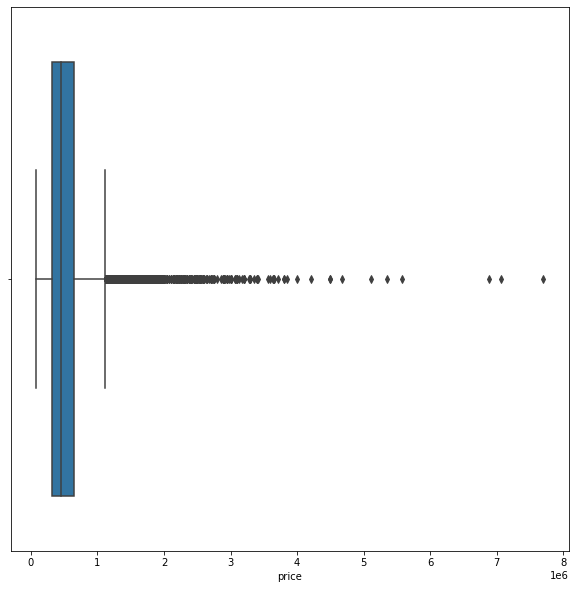

In [26]:
#looking at price
fig, ax = plt.subplots(figsize = (10, 10))
sns.boxplot(x = df_copy['price']);

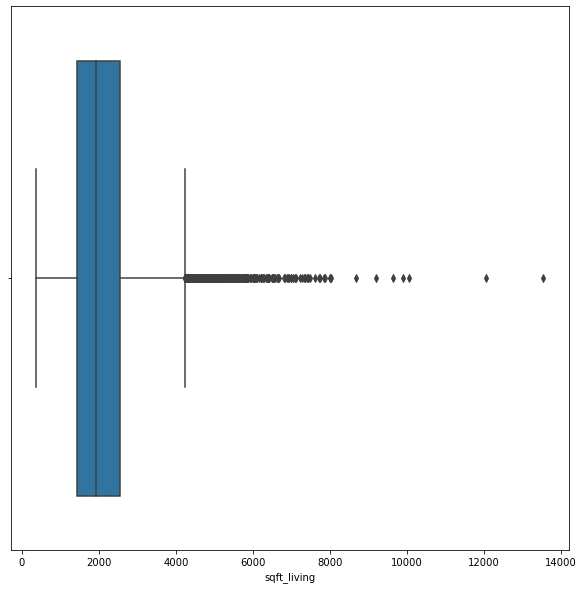

In [27]:
#looking into sqft_living
fig, ax = plt.subplots(figsize = (10, 10))
sns.boxplot(x = df_copy['sqft_living']);

There are a substantial enough number of outliers in terms of both `sqft_living` area and sale `price` that we chose to trim down the dataset to reduce the potential for skewing. Below, we calculate an interquartile range for both `price` and `sqft_living` data to determine the 'cutoff points.'

In [28]:
# Finding cut-off point: `price` IQR with mean price
q3, q1 = np.percentile(df_copy['price'], [75, 25])
q3, q1
iqr = q3-q1

lower_limit = df_copy['price'].mean()- (iqr*1.5)

upper_limit = df_copy['price'].mean()+ (iqr*1.5)

lower_limit, upper_limit

(61563.248080164776, 1021713.2480801648)

In [29]:
#using median
q3, q1 = np.percentile(df_copy['price'], [75, 25])
q3, q1
iqr = q3-q1

lower_limit2 = df_copy['price'].median()- (iqr*1.5)

upper_limit2 = df_copy['price'].median()+ (iqr*1.5)

lower_limit2, upper_limit2

(-29825.0, 930325.0)

Upon further discussion, we decide to use median because mean is more affect by the present of outliers compared to median. Although, they differ by about \\$10K, in data this is enough to skew our results in one direction.

In [30]:
#droppped big outliers base on median price, narrowing down the market
df_copy = df_copy[df_copy['price'] < upper_limit2]

In [31]:
#Finding where our outliers are in sqft_living
q3, q1 = np.percentile(df_copy['sqft_living'], [75, 25])
q3, q1
iqr = q3-q1

living_lower_limit = df_copy['sqft_living'].median()- (iqr*1.5)

living_upper_limit = df_copy['sqft_living'].median()+ (iqr*1.5)

living_lower_limit, living_upper_limit

(330.0, 3330.0)

Similar to the issue of price, we decide on median as we had big outliers that can skew the regrression.

In [32]:
#dropping sqft_living outliers
df_copy = df_copy[df_copy['sqft_living'] < living_upper_limit]

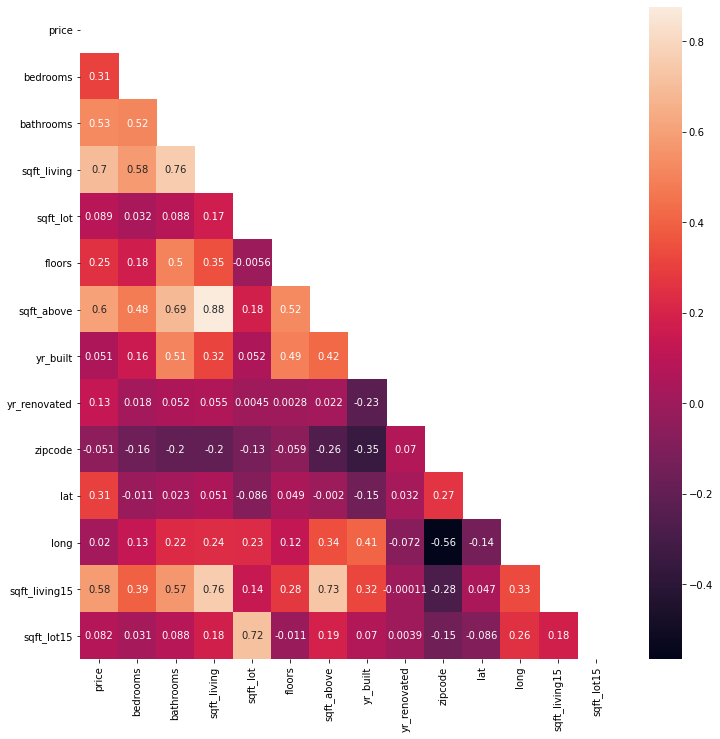

In [33]:
# Visualizing correlations between numerical columns
# with a seaborn heatmap to investigate the correlation

fig, ax = plt.subplots(figsize=(12, 12))
corr = df.corr()

# Instantiate numpy array of zeroes and assign to `mask`
mask = np.zeros_like(corr,
                     dtype=bool)

# Returns indices from upper triangle of array
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr,
            annot=True,
            mask=mask);

**Observations from this heatmap:**

- `sqft_living` has the highest correlation with price, an r-value of `0.7`...
    - ...but `sqft_living` is also correlated with several other columns: `bedrooms`, `bathrooms`, `sqft_above` (this one has an r-value of `0.88`!), and `sqft_living15`, so we'll need to be careful that we don't include collinear features in our models.
- `zipcode`, `lat`, and `long` all have low (`0.31` or below) correlations with `price` - these columns may not be immediately useful to us in constructing models for this project, but could be worth looking into as next-step recommendations.

In [34]:
#looking at bedroom and bath rooms
df_copy.bedrooms.value_counts()

3     9156
4     5418
2     2685
5      987
1      189
6      158
7       18
8        5
11       1
10       1
33       1
Name: bedrooms, dtype: int64

In [35]:
df_copy.bathrooms.value_counts()

2.50    4727
1.00    3766
1.75    2924
2.00    1851
2.25    1832
1.50    1393
2.75     927
3.00     525
3.50     277
3.25     239
0.75      69
3.75      34
4.00      27
4.50       8
1.25       7
5.00       4
4.25       4
0.50       4
5.25       1
Name: bathrooms, dtype: int64

We notice that the bedrooms and bathrooms are categorical, so the correlation between the bathrooms, bedrooms and sqft_living is not actually what we see in the correlation map.

In [36]:
# Converting bedroom/bathrooms to ensure they remain categorical when we scale
df_copy.bedrooms = df_copy.bedrooms.astype(str)
df_copy.bathrooms  = df_copy.bathrooms.astype(str)

In [37]:
#dropping inaccurate data and data with 1 sample
df_copy = df_copy[(df_copy['bedrooms'] != 33) & (df_copy['bedrooms'] != 10) & (df_copy['bedrooms'] != 11) &
                 (df_copy['bathrooms'] != 5.25)]

In [39]:
# Drop irrelevant columns
df_copy.drop(columns=['date',
                      'floors',
                      'waterfront',
                      'condition',
                      'sqft_above',  # potential for multicollinearity
                      'sqft_basement',  # potential for multicollinearity
                      'yr_renovated',
                      'lat',
                      'long',
                      'sqft_living15',  # potential for multicollinearity
                      'sqft_lot15',
                      'zipcode', 'yr_built'],
             inplace=True)

In the process of data exploration, we noticed when plotting `sqft_living` against `price` that the residuals had a *heteroskedastic* pattern; in keeping with the assumptions of linear regression, we transform the `price` column with `np.log()`.

In [40]:
# Transforming price column
df_copy['price'] = np.log(df_copy['price'])

All set to begin preprocessing!

# Splitting data into train and test sets

Our **target** variable, or `y`, is going to be `price`, i.e. the sale price of a given home.

In [41]:
# Creating target variable and predictor dataframe
y = df_copy['price']
X = df_copy.drop(labels='price',
                 axis=1)

In [42]:
# Initiating train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [43]:
# Did it split correctly?
len(X_train + X_test) == len(X)

True

In [44]:
# Did it split correctly?
len(X_train + X_test) == len(X)

True

In [45]:
# Setting Baseline model for train

# Instantiate
dummy_lr = DummyRegressor()

# Create variables
X_t = X_train
y_t = y_train

# Fit
dummy_lr.fit(X_t,y_t)

# Score
dummy_lr.score(X_t,y_t)

#predict
dummy_pred1 = dummy_lr.predict(X_t)

#RMSE
print(mean_squared_error(np.exp(y_t), np.exp(dummy_pred1), squared=False))
print(r2_score(y_t, dummy_pred1))

179617.6986991136
0.0


In [46]:
# Setting Baseline model for test

# Create variables
X_test1 = X_test
y_test1 = y_test

# Score
dummy_lr.score(X_test1,y_test1)

#predict
dummy_pred2 = dummy_lr.predict(X_test1)

#RMSE
print(mean_squared_error(np.exp(y_test1), np.exp(dummy_pred2), squared=False))
print(r2_score(y_test1,dummy_pred2))

181742.40582709413
-2.696336780516617e-07


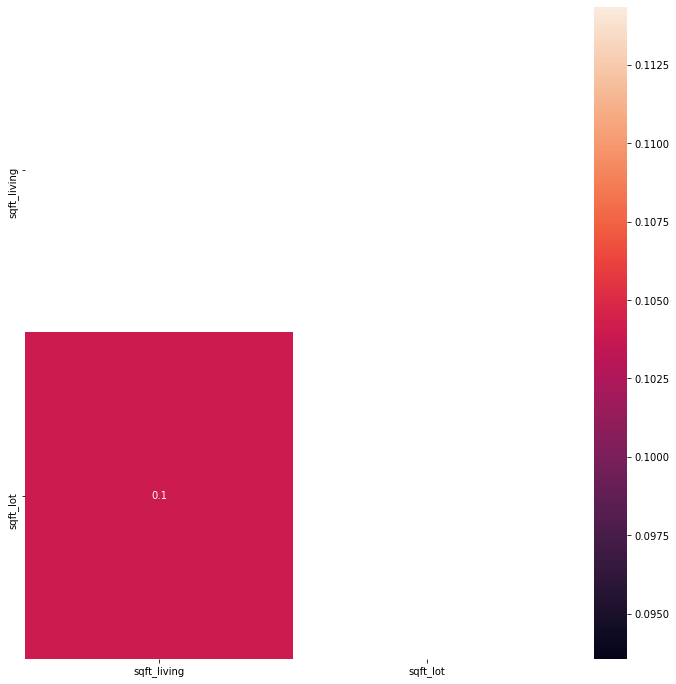

In [47]:
#looking at coefficients once again to see what the chancges are for relationship between the features
fig, ax = plt.subplots(figsize=(12, 12))
corr = X_train.corr()

# Instantiate numpy array of zeroes and assign to `mask`
mask = np.zeros_like(corr,
                     dtype=bool)

# Returns indices from upper triangle of array
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr,
            annot=True,
            mask=mask);

## SCALING AND OHE

Now that we've established what our baseline model, we can now move on to adjusting our features as these transformation here affects model being built.

In [48]:
scaler = StandardScaler()

# Calling to certain columns
continous = [c for c in X_train.columns if (X_train[c].dtype == 'int64')| (X_train[c].dtype == 'float64')]

#transform the dataframe with having to split into different dataframes of num and categorical
ct = ColumnTransformer(transformers=[('scale', scaler, continous)],
                       remainder='drop')
ct.fit(X_train)

# Transform training data
X_train_scaled = X_train.copy()
X_train_trans = ct.transform(X_train)

#prevents the conversion of numerical columns into objects by saving over
X_train_scaled[continous] = X_train_trans

# Scaling testing data
X_test_scaled = X_test.copy()

X_test_trans = ct.transform(X_test)
X_test_scaled[continous] = X_test_trans

In [49]:
#creating list of columns
cat_cols = [c for c in X_train_scaled.columns if X_train_scaled[c].dtype == 'O']

encoder = OneHotEncoder(drop='if_binary', handle_unknown='ignore')

# Create an columntransformer object.
ct2 = ColumnTransformer(transformers=[('ohe', encoder, cat_cols)],
                       remainder='passthrough')
ct2.fit(X_train_scaled)
X_train_enc = ct2.transform(X_train_scaled)
X_train_enc

#OHE testing
X_test_enc = ct2.transform(X_test_scaled)
X_test_enc

C:\Users\xiaoh\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


<6145x44 sparse matrix of type '<class 'numpy.float64'>'
	with 36869 stored elements in Compressed Sparse Row format>

In [50]:
scaled_p_df = pd.DataFrame(X_train_enc.todense() ,columns= ct2.get_feature_names_out(), index = y_train.index)
scaled_test_df= pd.DataFrame(X_test_enc.todense(), columns= ct2.get_feature_names_out(), index = y_test.index)

In [51]:
scaled_p_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12474 entries, 7139 to 18201
Data columns (total 44 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ohe__bedrooms_1           12474 non-null  float64
 1   ohe__bedrooms_10          12474 non-null  float64
 2   ohe__bedrooms_2           12474 non-null  float64
 3   ohe__bedrooms_3           12474 non-null  float64
 4   ohe__bedrooms_33          12474 non-null  float64
 5   ohe__bedrooms_4           12474 non-null  float64
 6   ohe__bedrooms_5           12474 non-null  float64
 7   ohe__bedrooms_6           12474 non-null  float64
 8   ohe__bedrooms_7           12474 non-null  float64
 9   ohe__bedrooms_8           12474 non-null  float64
 10  ohe__bathrooms_0.5        12474 non-null  float64
 11  ohe__bathrooms_0.75       12474 non-null  float64
 12  ohe__bathrooms_1.0        12474 non-null  float64
 13  ohe__bathrooms_1.25       12474 non-null  float64
 14  ohe

In [52]:
#cleaning the column names for easier access
scaled_p_df.columns = [x.replace("ohe__", "").replace('remainder__','').strip() for x in scaled_p_df.columns]
scaled_test_df.columns = [x.replace("ohe__", "").replace('remainder__','').strip() for x in scaled_test_df.columns]

In [53]:
#dropping a columns as we did not do this in our ohe
scaled_p_df.drop(columns = ['view_FAIR', 'grade_4_Low','bedrooms_8', 'bathrooms_5.0'], inplace = True)
scaled_test_df.drop(columns = ['view_FAIR', 'grade_4_Low','bedrooms_8','bathrooms_5.0'], inplace = True)

# Linear Modeling

In [54]:
#function that gather relevant information from train models
def scores(x,y):
    regressor = LinearRegression()
    regressor.fit(x,y)
    y_pred = regressor.predict(x)
    result1 = regressor.score(x,y)
    result2 = r2_score(y,y_pred)
    rmse = mean_squared_error(np.exp(y), np.exp(y_pred), squared=False)
    
    print("Model train score is:", result1) 
    print("Train r2_score is:", result2)
    print("The train RMSE is:" , rmse)

## Initial Model - Simple Linear Regression with `sqft_living`

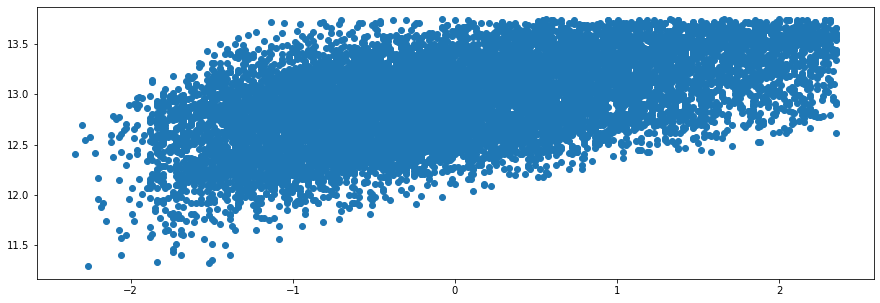

In [55]:
#taking a look at the relationship once more before we start
fig, ax = plt.subplots(figsize = (15,5))

x = scaled_p_df['sqft_living']
y = y_train


ax.scatter(x, y);

In [56]:
#Correlation between these X_train feature to y_train
np.corrcoef(x,y)

array([[1.        , 0.53537746],
       [0.53537746, 1.        ]])

The correlation drops from .7 to .57 after cleaning the data for outliers and splitting to train-test.

In [57]:
# Baseline model

# Instantiate
dummy_lr = DummyRegressor()

# Create variables
X = scaled_p_df['sqft_living']
y = y_train

# Fit
dummy_lr.fit(X,y)

# Score
dummy_lr.score(X,y)

#predict
dummy_pred = dummy_lr.predict(X)

#RMSE
mean_squared_error(np.exp(y), np.exp(dummy_pred), squared=False)

179617.6986991136

### Assumption testing

In [58]:
X = scaled_p_df[['sqft_living']]
y = y_train

model = LinearRegression()
model.fit(X,y)
y_pred = model.predict(X)

resids = y - y_pred

scores(X,y)

Model train score is: 0.28662901943676633
Train r2_score is: 0.28662901943676633
The train RMSE is: 151104.6021305913


In [59]:
# Create bins count for histogram
bins = int( len(X)**.5)
bins

111

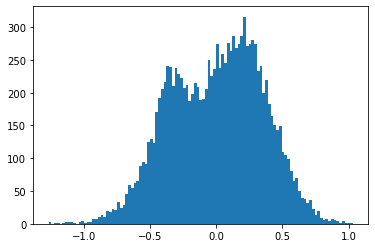

In [60]:
# Histogram of residuals

plt.hist(resids, bins=bins);

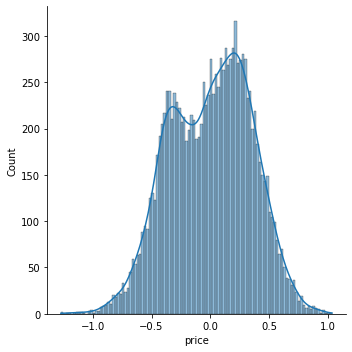

In [61]:
sns.displot(resids, bins=bins, kde=True)

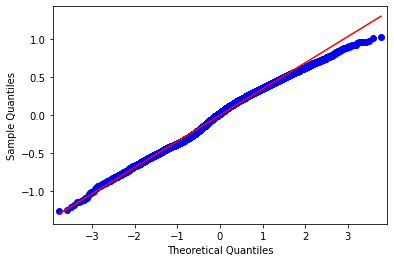

In [62]:
sm.qqplot(resids, line='r');

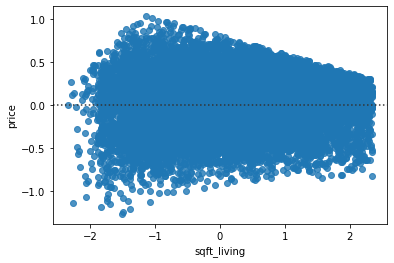

In [63]:
# resid plot sns.resid

sns.residplot(x=X, y=y);

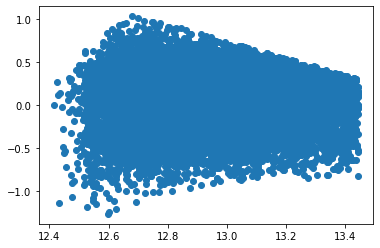

In [64]:
plt.scatter(y_pred, resids);

Our simple linear regression for the most part passes the assumption of linear regression as our residuals are more or less normally distributes, homoskedactic, and the qqplot is more or less mostly linear.

## Modeling with Multiple Features

In [65]:
scaled_p_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12474 entries, 7139 to 18201
Data columns (total 40 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bedrooms_1           12474 non-null  float64
 1   bedrooms_10          12474 non-null  float64
 2   bedrooms_2           12474 non-null  float64
 3   bedrooms_3           12474 non-null  float64
 4   bedrooms_33          12474 non-null  float64
 5   bedrooms_4           12474 non-null  float64
 6   bedrooms_5           12474 non-null  float64
 7   bedrooms_6           12474 non-null  float64
 8   bedrooms_7           12474 non-null  float64
 9   bathrooms_0.5        12474 non-null  float64
 10  bathrooms_0.75       12474 non-null  float64
 11  bathrooms_1.0        12474 non-null  float64
 12  bathrooms_1.25       12474 non-null  float64
 13  bathrooms_1.5        12474 non-null  float64
 14  bathrooms_1.75       12474 non-null  float64
 15  bathrooms_2.0        12474 non-nu

In [66]:
all_features = scaled_p_df.copy()

In [67]:
all_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12474 entries, 7139 to 18201
Data columns (total 40 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bedrooms_1           12474 non-null  float64
 1   bedrooms_10          12474 non-null  float64
 2   bedrooms_2           12474 non-null  float64
 3   bedrooms_3           12474 non-null  float64
 4   bedrooms_33          12474 non-null  float64
 5   bedrooms_4           12474 non-null  float64
 6   bedrooms_5           12474 non-null  float64
 7   bedrooms_6           12474 non-null  float64
 8   bedrooms_7           12474 non-null  float64
 9   bathrooms_0.5        12474 non-null  float64
 10  bathrooms_0.75       12474 non-null  float64
 11  bathrooms_1.0        12474 non-null  float64
 12  bathrooms_1.25       12474 non-null  float64
 13  bathrooms_1.5        12474 non-null  float64
 14  bathrooms_1.75       12474 non-null  float64
 15  bathrooms_2.0        12474 non-nu

In [68]:
scores(all_features, y_train)

Model train score is: 0.3996251049648625
Train r2_score is: 0.3996251049648625
The train RMSE is: 138610.6375316526


In [69]:
no_bathrooms = all_features[all_features.columns.drop(list(all_features.filter(regex='bathrooms')))]

In [70]:
scores(no_bathrooms, y_train)

Model train score is: 0.3908006494598536
Train r2_score is: 0.3908006494598536
The train RMSE is: 139658.26474431707


In [71]:
no_bathrooms_bedrooms = no_bathrooms[no_bathrooms.columns.drop(\
                                    list(no_bathrooms.filter(regex= 'bedrooms')))]

In [72]:
scores(no_bathrooms_bedrooms, y_train)

Model train score is: 0.38348472943581713
Train r2_score is: 0.38348472943581713
The train RMSE is: 140244.28774474948


In [73]:
no_bathrooms_bedrooms_lot = no_bathrooms_bedrooms.drop(columns = 'sqft_lot')

In [74]:
scores(no_bathrooms_bedrooms_lot, y_train)

Model train score is: 0.38341105514981666
Train r2_score is: 0.38341105514981666
The train RMSE is: 140238.58459197267


In [75]:
no_view = no_bathrooms_bedrooms_lot[no_bathrooms_bedrooms_lot.columns.drop(\
                                    list(no_bathrooms_bedrooms_lot.filter(regex= 'view')))]

In [76]:
scores(no_view, y_train)

Model train score is: 0.3691259906145282
Train r2_score is: 0.3691259906145282
The train RMSE is: 141942.1695015026


In [77]:
no_grade = no_bathrooms_bedrooms_lot[no_bathrooms_bedrooms_lot.columns.drop(\
                                    list(no_bathrooms_bedrooms_lot.filter(regex= 'grade')))]

In [78]:
scores(no_grade, y_train)

Model train score is: 0.3012903977222816
Train r2_score is: 0.3012903977222816
The train RMSE is: 149367.5733879837


Between looking at a model that has two features, we saw that dropping grade dropped the r2 to .36 versus when we dropped view which was .49.

Overall, we find that the model that explained te most variance in pricing is the model with all the features that we had chosen which is sqft_lot, bedrooms, bathrooms, view, grade and sqft_living. The main issue with this model is that the bedrooms and bathrooms are potentially multicolinear with sqft_living.

In [79]:
#our all features model in statmodel
#statmodel version
all_var = sm.OLS(y_train, sm.add_constant(all_features)).fit()
all_var.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.400
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     206.9
Date:                Fri, 01 Apr 2022   Prob (F-statistic):               0.00
Time:                        10:25:51   Log-Likelihood:                -3389.3
No. Observations:               12474   AIC:                             6861.
Df Residuals:                   12433   BIC:                             7165.
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  12.5525      0.210     59.680      0.000      12.140      12.965
bedrooms_1              0.0679      0.150      0.453      0.650      -0.226       0.361
bedrooms_10             0.2384      0.350      0.681      0.496      -0.448       0.925
bedrooms_2              0.0454      0.147      0.310      0.757      -0.242       0.333
bedrooms_3             -0.0617      0.146     -0.421      0.673      -0.349       0.225
bedrooms_33             0.4793      0.350      1.369      0.171      -0.207       1.166
bedrooms_4             -0.0727      0.146     -0.497      0.619      -0.359       0.214
bedrooms_5             -0.0717      0.147     -0.489      0.625      -0.359       0.216
bedrooms_6             -0.1141      0.149     -0.768      0.443      -0.405       0.177
bedrooms_7             -0.0957      0.173     -0.554      0.579      -0.434       0.243
bathrooms_0.5          -0.5397      0.280     -1.931      0.054      -1.088       0.008
bathrooms_0.75          0.0236      0.173      0.136      0.891      -0.315       0.362
bathrooms_1.0           0.0355      0.166      0.215      0.830      -0.289       0.360
bathrooms_1.25          0.1362      0.230      0.593      0.553      -0.314       0.586
bathrooms_1.5           0.0111      0.166      0.067      0.946      -0.314       0.336
bathrooms_1.75          0.0588      0.165      0.355      0.722      -0.266       0.383
bathrooms_2.0           0.0689      0.166      0.417      0.677      -0.256       0.393
bathrooms_2.25          0.0121      0.166      0.073      0.942      -0.312       0.337
bathrooms_2.5          -0.0458      0.165     -0.277      0.782      -0.370       0.278
bathrooms_2.75          0.0152      0.166      0.092      0.927      -0.309       0.340
bathrooms_3.0           0.0262      0.166      0.158      0.874      -0.299       0.351
bathrooms_3.25          0.0824      0.167      0.493      0.622      -0.245       0.410
bathrooms_3.5           0.0467      0.167      0.280      0.780      -0.280       0.374
bathrooms_3.75          0.1019      0.178      0.574      0.566      -0.246       0.450
bathrooms_4.0           0.1147      0.182      0.631      0.528      -0.241       0.471
bathrooms_4.25          0.1836      0.247      0.743      0.458      -0.301       0.668
bathrooms_4.5          -0.0945      0.203     -0.466      0.641      -0.492       0.303
bathrooms_5.25         -0.3958      0.358     -1.107      0.268      -1.097       0.305
view_AVERAGE           -0.0485      0.031     -1.589      0.112      -0.108       0.011
view_EXCELLENT          0.1236      0.049      2.531      0.011       0.028       0.219
view_GOOD              -0.0728      0.036     -2.012      0.044      -0.144      -0.002
view_NONE              -0.2025      0.026     -7.664      0.000      -0.254      -0.151
gra

##### Explain the coefficients of this model here and rmse of it which is \\$139571.53375696248

In [80]:
y_train.shape

(12474,)

## Testing best model on test data

In [103]:
def test_scores(x_test, y_test, X_train_model_data, y_train_model_data):
    
    model = LinearRegression()
    model.fit(X_train_model_data, y_train_model_data) #input the correct X_train to create the right model
    
    test_preds = model.predict(x_test)

    result1 = model.score(x_test, y_test)
    result2 = r2_score(y_test, test_preds)
    rmse = mean_squared_error(np.exp(y_test), np.exp(test_preds), squared=False)
    
    print("Model test score is:", result1) 
    print("Test r2_score is:", result2)
    print("The test data RMSE is:" , rmse)

The train model that had all features was had the highest r2 of about 0.4. As such, we will run our test data on this model to see what percentage of the variance we see in our price is explained by these features.

In [104]:
#train data score
scores(all_features, y_train)

Model train score is: 0.3996251049648625
Train r2_score is: 0.3996251049648625
The train RMSE is: 138610.6375316526


In [107]:
#test data score
test_scores(scaled_test_df, y_test,all_features,y_train)

Model test score is: 0.3874244802046618
Test r2_score is: 0.3874244802046618
The test data RMSE is: 141661.90332810802


#### Comparision of the r2 of test and train model here

## Statistical Analysis of View and Grade

###  View

is there a difference between those that have a view versus those that don't

In [84]:
summary_of_view = df_copy.groupby('view').agg(['mean', 'std'])

summary_of_view

price      sqft_living        sqft_lot          
           mean  std        mean    std     mean       std
view                                                      
AVERAGE   13.18 0.35     2081.44 634.67 20893.51  54804.27
EXCELLENT 13.36 0.30     2105.09 647.35 20259.54  30854.82
FAIR      13.21 0.34     2087.95 641.49 12078.11  20053.50
GOOD      13.23 0.33     2244.06 576.37 41259.38 129422.14
NONE      12.91 0.41     1828.20 620.90 12560.12  31509.43

In [85]:
#Created for analysis only
#should not be used anywhere else in the project besised t-tests
train_df = pd.concat([X_train, y_train], axis=1)

In [86]:
# Figure out how to do this in a loop/function?
df_average = train_df[train_df['view'] == 'AVERAGE']
df_excellent = train_df[train_df['view'] == 'EXCELLENT']
df_fair = train_df[train_df['view'] == 'FAIR']
df_good = train_df[train_df['view'] == 'GOOD']
df_none = train_df[train_df['view'] == 'NONE']

In [87]:
fvalue, pvalue = stats.f_oneway(df_average['price'], df_excellent['price'], df_fair['price'],
                                df_good['price'] , df_none['price'])

In [88]:
df_view = train_df[['view', 'price']]

print(pairwise_tukeyhsd(df_view['price'], df_view['view']))

   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1    group2  meandiff p-adj   lower   upper  reject
----------------------------------------------------------
  AVERAGE EXCELLENT   0.1881 0.0067   0.036  0.3402   True
  AVERAGE      FAIR   0.0461 0.7285 -0.0594  0.1516  False
  AVERAGE      GOOD   0.0286    0.9 -0.0726  0.1298  False
  AVERAGE      NONE  -0.2654  0.001 -0.3206 -0.2103   True
EXCELLENT      FAIR   -0.142 0.1447 -0.3104  0.0264  False
EXCELLENT      GOOD  -0.1595  0.066 -0.3253  0.0063  False
EXCELLENT      NONE  -0.4535  0.001  -0.596 -0.3111   True
     FAIR      GOOD  -0.0175    0.9 -0.1419  0.1069  False
     FAIR      NONE  -0.3115  0.001 -0.4026 -0.2205   True
     GOOD      NONE   -0.294  0.001   -0.38  -0.208   True
----------------------------------------------------------


Average - Fair , Average - Good, Excellent-good and Fair-Good are not statistically different from each other. BUT we should still note that Excellent-good has a p-value of 0.14, which may be considered statistically significant depending on the alpha set. For our purposes, we will not consider it significant as we set alpha to 0.05.

In [89]:
train_copy = train_df.copy()

In [90]:
train_copy.price = np.exp(train_copy.price)

In [91]:
view_graph = train_copy.groupby('view').mean()

In [92]:
view_graph.sort_values('price', ascending= True, inplace = True)

In [93]:
view_graph

,sqft_living,sqft_lot,price
view,,,
NONE,1832.22,12500.63,438148.14
AVERAGE,2085.57,22320.73,557277.84
GOOD,2211.48,49809.40,571215.78
FAIR,2069.76,13089.13,583198.49
EXCELLENT,2126.07,22134.98,661264.75


<BarContainer object of 5 artists>

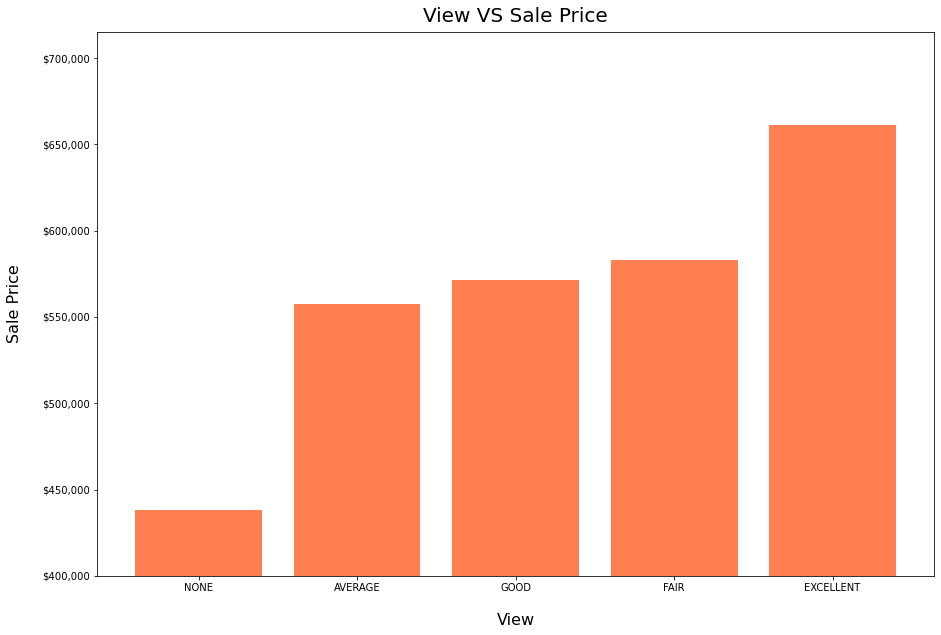

In [94]:
fig, ax = plt.subplots(figsize = (15, 10))

x = view_graph.index
y = view_graph['price'] 
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))

ax.set_title('View VS Sale Price', fontsize='20', pad=10)
ax.set_xlabel('View', fontsize='16', labelpad=20)
ax.set_ylabel('Sale Price', fontsize='16', labelpad=20)
ax.set_ylim([400000, 715000])


ax.bar(x, y, color='coral')

#plt.savefig('./images/view.png')

### `grade` Analysis

 Is there a difference between grades

In [95]:
# Might need a for loop or a function here
df_10 = train_df[train_df['grade'] == '10_Very_Good']
df_11 = train_df[train_df['grade'] == '11_Excellent']
df_4 = train_df[train_df['grade'] == '4_Low']
df_5 = train_df[train_df['grade'] == '5_Fair']
df_6 = train_df[train_df['grade'] == '6_Low_Average']
df_7 = train_df[train_df['grade'] == '7_Average']
df_8 = train_df[train_df['grade'] == '8_Good']
df_9 = train_df[train_df['grade'] == '9_Better']

In [96]:
f_value_grade, p_value_grade = stats.f_oneway(df_10['price'], df_11['price'],
                                              df_4['price'], df_5['price'], df_6['price'],
                                              df_7['price'], df_8['price'], df_9['price'])
p_value_grade

0.0

In [97]:
# Ad-hoc test to determine differeces in price vs. grade

df_grade = train_df[['grade', 'price']]

print(pairwise_tukeyhsd(train_df['price'], train_df['grade']))

       Multiple Comparison of Means - Tukey HSD, FWER=0.05        
    group1        group2    meandiff p-adj   lower   upper  reject
------------------------------------------------------------------
 10_Very_Good  11_Excellent   0.1082    0.9 -0.1665  0.3828  False
 10_Very_Good         4_Low  -1.3092  0.001 -1.5498 -1.0687   True
 10_Very_Good        5_Fair   -1.181  0.001 -1.2901 -1.0719   True
 10_Very_Good 6_Low_Average  -0.9533  0.001 -1.0307 -0.8759   True
 10_Very_Good     7_Average  -0.6743  0.001 -0.7476  -0.601   True
 10_Very_Good        8_Good  -0.4117  0.001 -0.4857 -0.3378   True
 10_Very_Good      9_Better  -0.1857  0.001 -0.2637 -0.1076   True
 11_Excellent         4_Low  -1.4174  0.001  -1.768 -1.0668   True
 11_Excellent        5_Fair  -1.2892  0.001 -1.5666 -1.0117   True
 11_Excellent 6_Low_Average  -1.0615  0.001  -1.328 -0.7949   True
 11_Excellent     7_Average  -0.7825  0.001 -1.0479 -0.5171   True
 11_Excellent        8_Good  -0.5199  0.001 -0.7854 -0.2543   

#### talk about what you see with the tukey test

In [98]:
grade_graph = train_copy.groupby('grade').mean()

In [99]:
grade_graph.sort_values('price', ascending= True, inplace = True)

<ipython-input-100-bc60db856c31>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(grade_ticks, fontsize='13')
<ipython-input-100-bc60db856c31>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(price_ticks, fontsize='13')


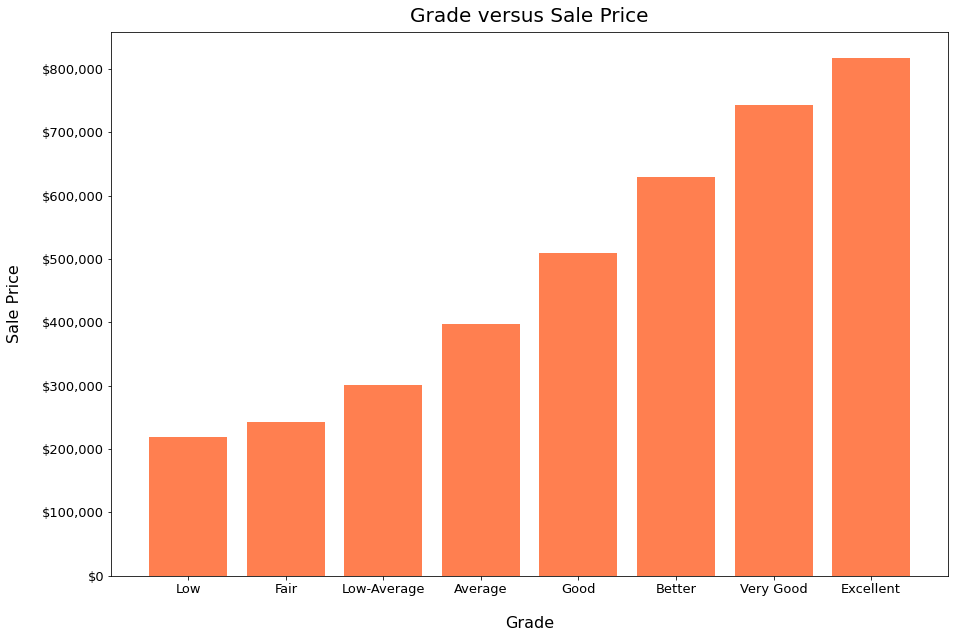

In [100]:
fig, ax = plt.subplots(figsize = (15, 10))

grade_ticks = ["Low", "Fair", "Low-Average",
               "Average", "Good", "Better",
               "Very Good", "Excellent"]
price_ticks = ["$0", "$100,000", "$200,000",
               "$300,000", "$400,000", "$500,000",
               "$600,000", "$700,000", "$800,000"]


x = grade_graph.index
y = grade_graph['price'] 

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))

ax.set_title('Grade versus Sale Price', fontsize='20', pad=10)
ax.set_xticklabels(grade_ticks, fontsize='13')
ax.set_yticklabels(price_ticks, fontsize='13')
ax.set_xlabel('Grade', fontsize='16', labelpad=20)
ax.set_ylabel('Sale Price', fontsize='16', labelpad=20)


ax.bar(x, y, color='coral')

plt.savefig('./images/grade.png')
# Ignore warnings?

### `sqft_living` Analysis

if you guys plan on putting something here

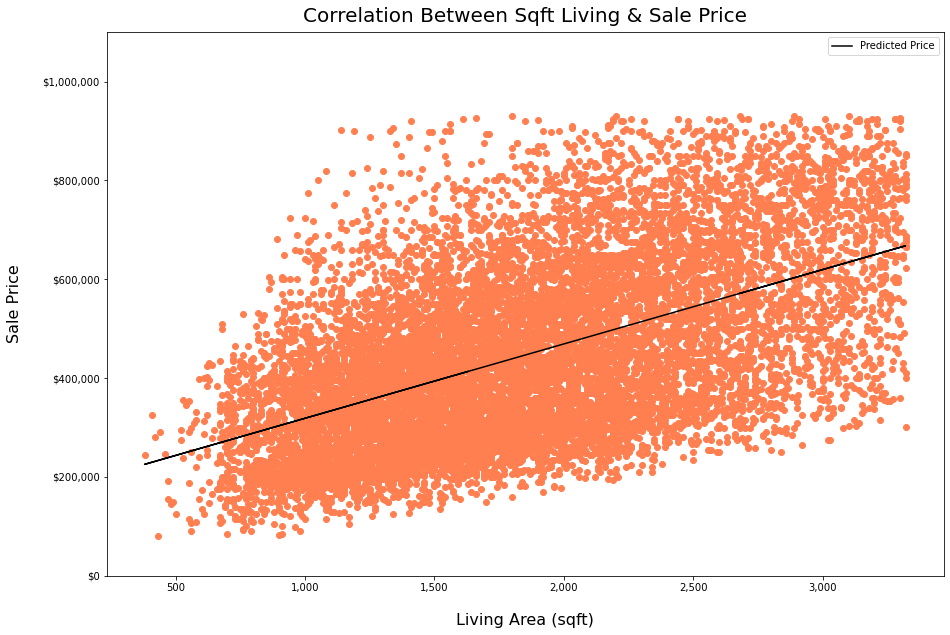

In [101]:
fig, ax = plt.subplots(figsize=(15,10))

x = X_train['sqft_living']
y = np.exp(y_train) 


m,b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, c="black")


ax.set_ylim([0,1100000])

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'));

ax.set_title('Correlation Between Sqft Living & Sale Price', fontsize='20', pad=10)
ax.set_xlabel('Living Area (sqft)', fontsize='16', labelpad=20)
ax.set_ylabel('Sale Price', fontsize='16', labelpad=20)

plt.legend(['Predicted Price'])

ax.scatter(x, y, color='coral');
plt.savefig('./images/sqftliving.png')

In [102]:
X_train['sqft_living'].describe()

count   12474.00
mean     1849.87
std       626.85
min       380.00
25%      1370.00
50%      1790.00
75%      2290.00
max      3320.00
Name: sqft_living, dtype: float64

# Potential Next Steps

- `bathrooms` and `bedrooms` - they are collinear with variables like `sqft_living`, which prevented us from including them in our model, but they might be useful avenues for further exploration.
- `waterfront` - our EDA demonstrated a significant difference in `price` between homes with waterfront views vs. homes without; it may be worth further exploring what development opportunities exist in waterfront areas.
- `zipcode` - taking a look at what neighborhoods/geographic areas yield high sale prices.
    - Look at interaction items: if homes with `EXCELLENT` views are concentrated in certain areas, perhaps.